In [7]:
# %pip install pandas_datareader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import pandas_datareader as data

In [26]:
import yfinance as yf
start = '2010-01-01'
end = '2020-01-01'


data = yf.download('AAPL', start=start, end=end)
data.head()

C:\Users\Nayamat\AppData\Local\Temp\ipykernel_1208\2809600392.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download('AAPL', start=start, end=end)
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2010-01-04,6.431897,6.446623,6.382908,6.414465,493729600
2010-01-05,6.443016,6.479382,6.409054,6.449628,601904800
2010-01-06,6.340532,6.468563,6.333920,6.443017,552160000
2010-01-07,6.328811,6.371489,6.282828,6.363975,477131200
2010-01-08,6.370888,6.371489,6.283130,6.320397,447610800


In [27]:
data.tail()

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2019-12-24,68.732895,68.882809,68.406488,68.834449,48478800
2019-12-26,70.096581,70.113507,68.836870,68.865884,93121200
2019-12-27,70.069977,71.078233,69.663776,70.389138,146266000
2019-12-30,70.485855,70.768750,68.962598,69.987774,144114400
2019-12-31,71.000854,71.008108,70.002272,70.101405,100805600


In [28]:
data.reset_index(inplace=True)
data.head()

Price,Date,Close,High,Low,Open,Volume
Ticker,,AAPL,AAPL,AAPL,AAPL,AAPL
0,2010-01-04,6.431897,6.446623,6.382908,6.414465,493729600
1,2010-01-05,6.443016,6.479382,6.409054,6.449628,601904800
2,2010-01-06,6.340532,6.468563,6.333920,6.443017,552160000
3,2010-01-07,6.328811,6.371489,6.282828,6.363975,477131200
4,2010-01-08,6.370888,6.371489,6.283130,6.320397,447610800


In [29]:
data = data.drop(['Date'], axis=1)
data.head()

C:\Users\Nayamat\AppData\Local\Temp\ipykernel_1208\2757609117.py:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  data = data.drop(['Date'], axis=1)


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
0,6.431897,6.446623,6.382908,6.414465,493729600
1,6.443016,6.479382,6.409054,6.449628,601904800
2,6.340532,6.468563,6.333920,6.443017,552160000
3,6.328811,6.371489,6.282828,6.363975,477131200
4,6.370888,6.371489,6.283130,6.320397,447610800


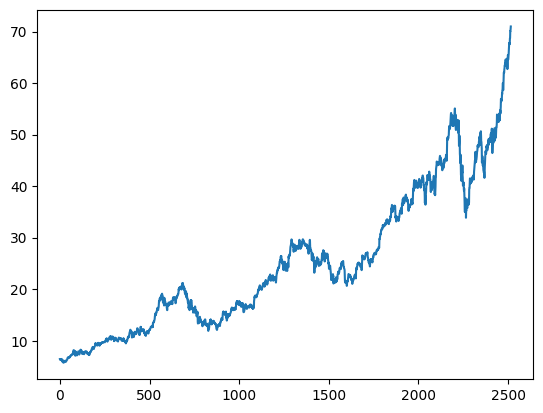

In [30]:
plt.plot(data['Close'])

In [31]:
data

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
0,6.431897,6.446623,6.382908,6.414465,493729600
1,6.443016,6.479382,6.409054,6.449628,601904800
2,6.340532,6.468563,6.333920,6.443017,552160000
3,6.328811,6.371489,6.282828,6.363975,477131200
4,6.370888,6.371489,6.283130,6.320397,447610800
...,...,...,...,...,...
2511,68.732895,68.882809,68.406488,68.834449,48478800
2512,70.096581,70.113507,68.836870,68.865884,93121200
2513,70.069977,71.078233,69.663776,70.389138,146266000


In [32]:
ma100 = data['Close'].rolling(100).mean()
ma100 #moving average of 100 days

Ticker,AAPL
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
2511,57.335283
2512,57.571941
2513,57.799543
2514,58.026404


Text(0.5, 1.0, 'Close Price History')

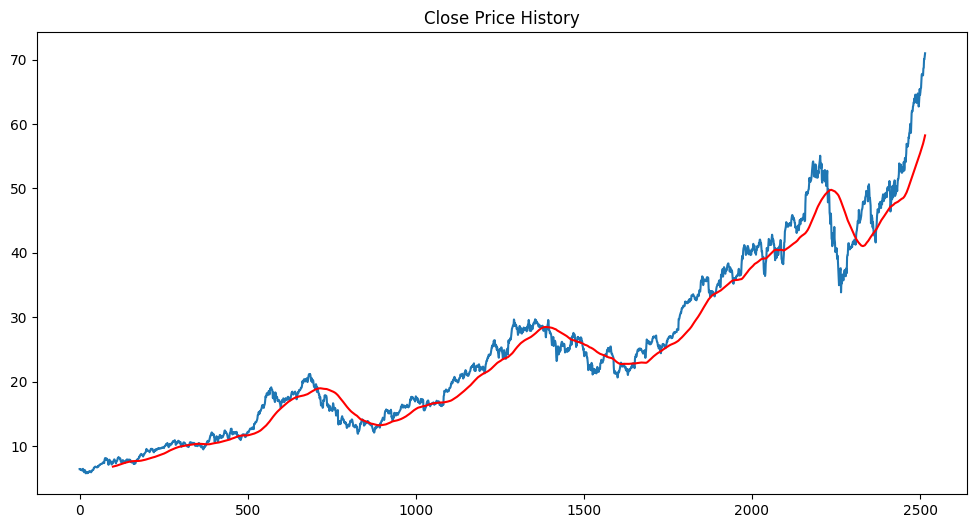

In [33]:
plt.figure(figsize=(12,6))
plt.plot(data['Close'])
plt.plot(ma100, 'r')
plt.title('Close Price History')

In [34]:
ma200 = data['Close'].rolling(200).mean()
ma200 #moving average of 200 days

Ticker,AAPL
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
2511,52.223418
2512,52.356549
2513,52.487130
2514,52.616932


Text(0.5, 1.0, 'Close Price History')

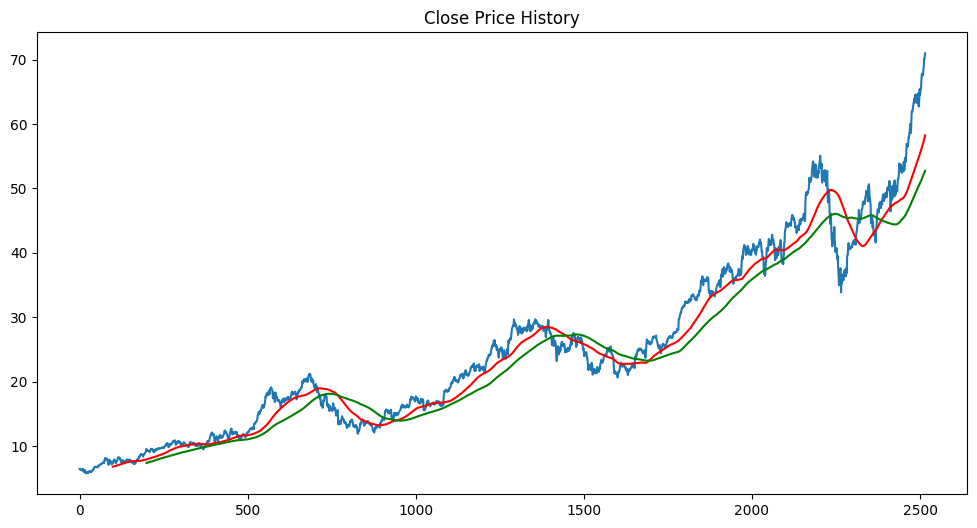

In [35]:
plt.figure(figsize=(12,6))
plt.plot(data['Close'])
plt.plot(ma100, 'r')
plt.plot(ma200, 'g')
plt.title('Close Price History')

In [36]:
data.shape

(2516, 5)

In [37]:
#splitting the data into training and testing data
data_training = pd.DataFrame(data['Close'][0:int(len(data)*0.70)])
data_testing = pd.DataFrame(data['Close'][int(len(data)*0.70):int(len(data))])
print(data_training.shape, data_testing.shape)

(1761, 1) (755, 1)


In [38]:
data_training.head()


Ticker,AAPL
0,6.431897
1,6.443016
2,6.340532
3,6.328811
4,6.370888


In [39]:
data_testing.head()

Ticker,AAPL
1761,26.751022
1762,26.827246
1763,26.797222
1764,26.933491
1765,27.233746


In [40]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

In [41]:
data_training_array= scaler.fit_transform(data_training)
data_training_array

array([[0.02759999],
       [0.02806499],
       [0.02377923],
       ...,
       [0.89123192],
       [0.88640234],
       [0.88611264]])

In [43]:
x_train = []
y_train = []

for i in range(100, data_training_array.shape[0]):
    x_train.append(data_training_array[i-100:i, 0])
    y_train.append(data_training_array[i, 0])

x_train , y_train = np.array(x_train), np.array(y_train)

In [44]:
#ML MODEL

In [45]:
from keras.layers import Dense, LSTM, Dropout
from keras.models import Sequential

In [46]:
model = Sequential()
model.add(LSTM(units=50, activation = 'relu',return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))



model.add(LSTM(units=60, activation = 'relu',return_sequences=True ))
model.add(Dropout(0.3))


model.add(LSTM(units=80, activation = 'relu',return_sequences=True))
model.add(Dropout(0.4))


model.add(LSTM(units=120, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(units=1))





c:\Users\Nayamat\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [47]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100, 60)        │        26,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100, 60)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 100, 80)        │        45,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100, 80)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 120)            │        96,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           121 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 178,761 (698.29 KB)

 Trainable params: 178,761 (698.29 KB)

 Non-trainable params: 0 (0.00 B)

In [48]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=50)

Epoch 1/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 35s 358ms/step - loss: 0.1389
Epoch 2/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 17s 333ms/step - loss: 0.0163
Epoch 3/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 17s 328ms/step - loss: 0.0128
Epoch 4/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 17s 317ms/step - loss: 0.0089
Epoch 5/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 17s 324ms/step - loss: 0.0100
Epoch 6/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 17s 329ms/step - loss: 0.0089
Epoch 7/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 17s 325ms/step - loss: 0.0081
Epoch 8/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 17s 326ms/step - loss: 0.0103
Epoch 9/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 17s 324ms/step - loss: 0.0075
Epoch 10/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 17s 327ms/step - loss: 0.0081
Epoch 11/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 17s 327ms/step - loss: 0.0080
Epoch 12/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 17s 324ms/step - loss: 0.0067
Epoch 13/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 17s 326ms/step - loss: 0.0071
Epoch 14/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 17s 321ms/step - loss: 0.0067
Epoch 15/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 17s 

In [49]:
model.save('keras_model.h5')

In [50]:
data_testing.head()

Ticker,AAPL
1761,26.751022
1762,26.827246
1763,26.797222
1764,26.933491
1765,27.233746


In [56]:
past_100_days = data_training.tail(100)
final_df = pd.concat([data_testing], ignore_index=True)
final_df.head()

Ticker,AAPL
0,26.751022
1,26.827246
2,26.797222
3,26.933491
4,27.233746


In [57]:
input_data = scaler.fit_transform(final_df)
input_data

array([[0.        ],
       [0.00172257],
       [0.00104407],
       [0.0041236 ],
       [0.01090904],
       [0.01654645],
       [0.0171728 ],
       [0.02051349],
       [0.01790363],
       [0.01680745],
       [0.02181834],
       [0.02176601],
       [0.02067013],
       [0.02181834],
       [0.02223606],
       [0.02166192],
       [0.03163142],
       [0.03194457],
       [0.03199677],
       [0.03032653],
       [0.028865  ],
       [0.06749066],
       [0.06634232],
       [0.06921327],
       [0.07552909],
       [0.0820016 ],
       [0.08466367],
       [0.08964379],
       [0.08807113],
       [0.09420472],
       [0.10327373],
       [0.10584239],
       [0.1050038 ],
       [0.10694353],
       [0.1120811 ],
       [0.11423027],
       [0.11118962],
       [0.11187101],
       [0.11328664],
       [0.11360112],
       [0.12827949],
       [0.12392839],
       [0.1282269 ],
       [0.12592075],
       [0.12686429],
       [0.12413805],
       [0.12246087],
       [0.124

In [58]:
input_data.shape

(755, 1)

In [59]:
x_test = []
y_test = []
for i in range(100, input_data.shape[0]):
    x_test.append(input_data[i-100:i, 0])
    y_test.append(input_data[i, 0]) 

In [60]:
x_test , y_test = np.array(x_test), np.array(y_test)
print(x_test.shape, y_test.shape)

(655, 100) (655,)


In [61]:
#making predictions

y_predicted = model.predict(x_test)
y_predicted.shape

21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step


(655, 1)

In [62]:
y_test

array([0.20542072, 0.20405259, 0.20436829, 0.19957822, 0.2017886 ,
       0.213738  , 0.20573693, 0.20847421, 0.21331713, 0.21131684,
       0.1796806 , 0.16094066, 0.16709955, 0.15957211, 0.15499247,
       0.14435904, 0.16578349, 0.15878227, 0.1633094 , 0.16204611,
       0.16546771, 0.16304647, 0.15204467, 0.16309906, 0.15178139,
       0.15357116, 0.1508337 , 0.15393978, 0.14678054, 0.15441341,
       0.15904572, 0.16151955, 0.162625  , 0.17331093, 0.17999612,
       0.18273331, 0.18547094, 0.19041903, 0.18683915, 0.1864707 ,
       0.19605144, 0.19947287, 0.20326301, 0.18799762, 0.18241745,
       0.1783642 , 0.18531301, 0.22263434, 0.2143699 , 0.21868652,
       0.2314249 , 0.23811025, 0.24326912, 0.21626459, 0.2276795 ,
       0.24020399, 0.24945197, 0.24601718, 0.22968737, 0.22778502,
       0.22625249, 0.23983416, 0.24089116, 0.23713886, 0.24025684,
       0.24876481, 0.25637509, 0.2587003 , 0.26213552, 0.26239941,
       0.25198856, 0.25109019, 0.24765531, 0.23375683, 0.24892

In [63]:
y_predicted

array([[0.22708729],
       [0.2290318 ],
       [0.2307665 ],
       [0.23230307],
       [0.23364387],
       [0.23479772],
       [0.23579782],
       [0.23667924],
       [0.23747447],
       [0.23822252],
       [0.23894936],
       [0.23958144],
       [0.23998713],
       [0.24006608],
       [0.23974794],
       [0.2389954 ],
       [0.23778802],
       [0.23619196],
       [0.23429567],
       [0.23220778],
       [0.23003277],
       [0.22787024],
       [0.22579649],
       [0.2238374 ],
       [0.22200507],
       [0.22030213],
       [0.21872276],
       [0.21725273],
       [0.21588583],
       [0.21460241],
       [0.21340196],
       [0.21230313],
       [0.21133322],
       [0.21051612],
       [0.20989266],
       [0.2095112 ],
       [0.20940758],
       [0.2095987 ],
       [0.21008936],
       [0.21085392],
       [0.21184546],
       [0.2130322 ],
       [0.21439168],
       [0.21590747],
       [0.21751611],
       [0.21912685],
       [0.2206443 ],
       [0.222

In [64]:
scaler.scale_

array([0.02259896])

In [65]:
scale_factor = 1/0.02259896
y_predicted = y_predicted * scale_factor
y_test = y_test * scale_factor

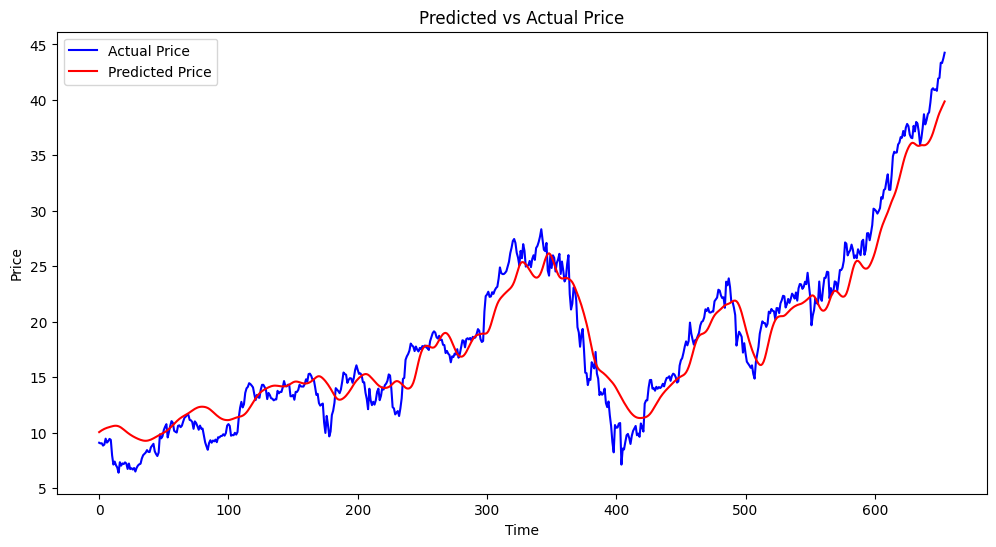

In [67]:
plt.figure(figsize=(12,6))
plt.plot(y_test, 'b', label='Actual Price') 
plt.plot(y_predicted, 'r', label='Predicted Price')
plt.title('Predicted vs Actual Price')  
plt.xlabel('Time')
plt.ylabel('Price') 
plt.legend()
plt.show()

In [69]:
from sklearn.metrics import mean_squared_error, r2_score
import math
mse = mean_squared_error(y_test, y_predicted)
rmse = math.sqrt(mse)
print("RMSE: ", rmse)
print("R2 Score: ", r2_score(y_test, y_predicted))
print("Mean Squared Error: ", mse)

RMSE:  2.019581227422382
R2 Score:  0.9347690435506715
Mean Squared Error:  4.078708334156895
